In [27]:
import pennylane as qml
from qco_new import *
from qco_new_joint import optimizeJoint, optimizeJoint_aug
from pennylane.transforms import *
from utils import show_graph


from qiskit import QuantumCircuit
from qiskit.transpiler.passes import UnitarySynthesis
from qiskit.transpiler import PassManager

In [2]:
[ds] = qml.data.load("ketgpt")

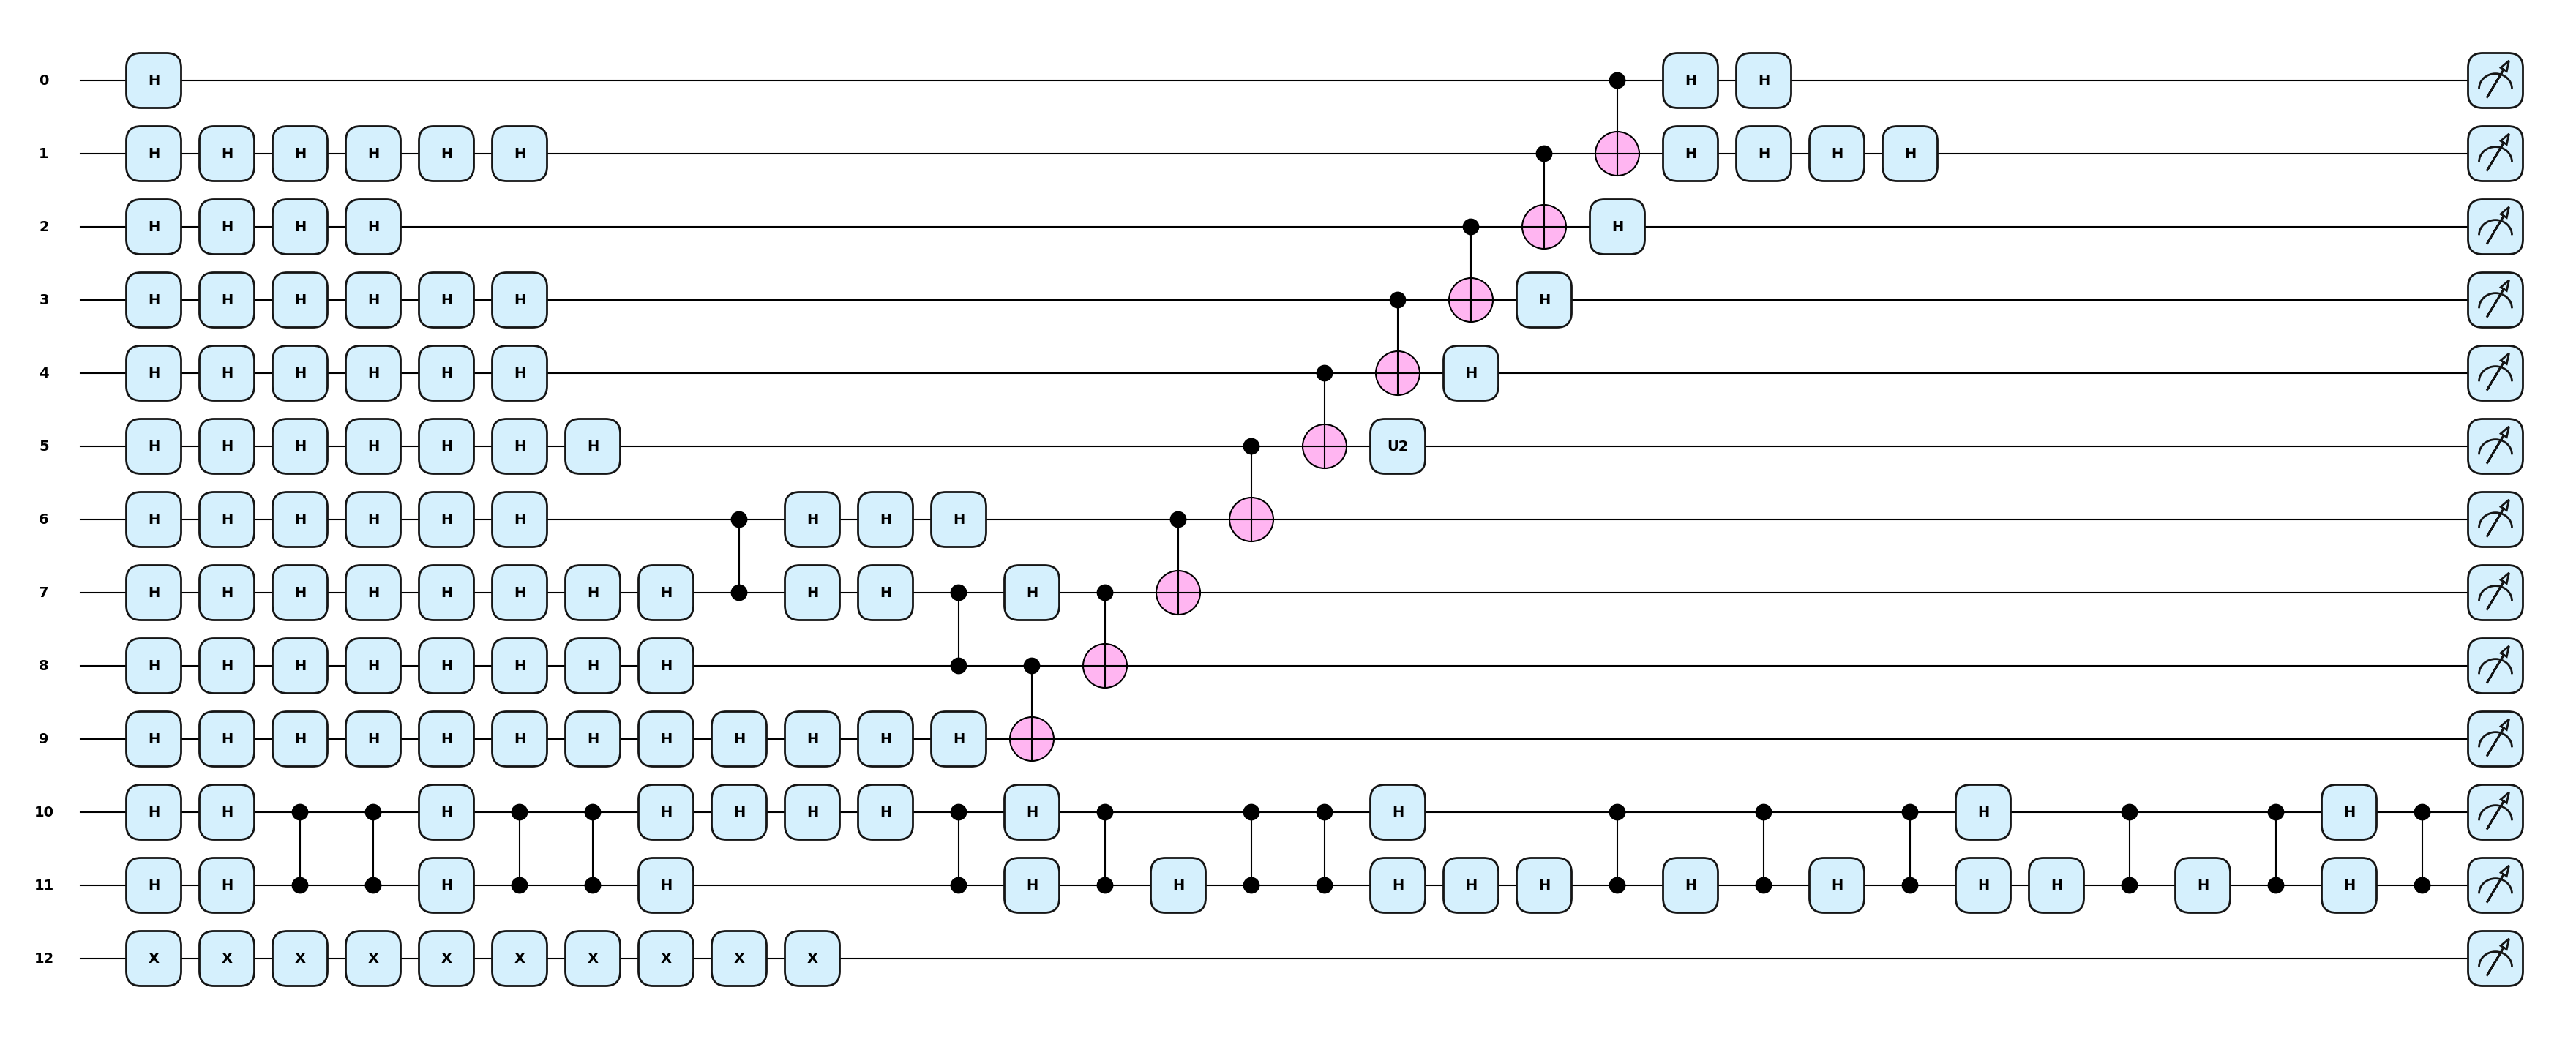

In [3]:
# example
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        else:
            qml.apply(op)
    return qml.state()

show_circuit(circuit)

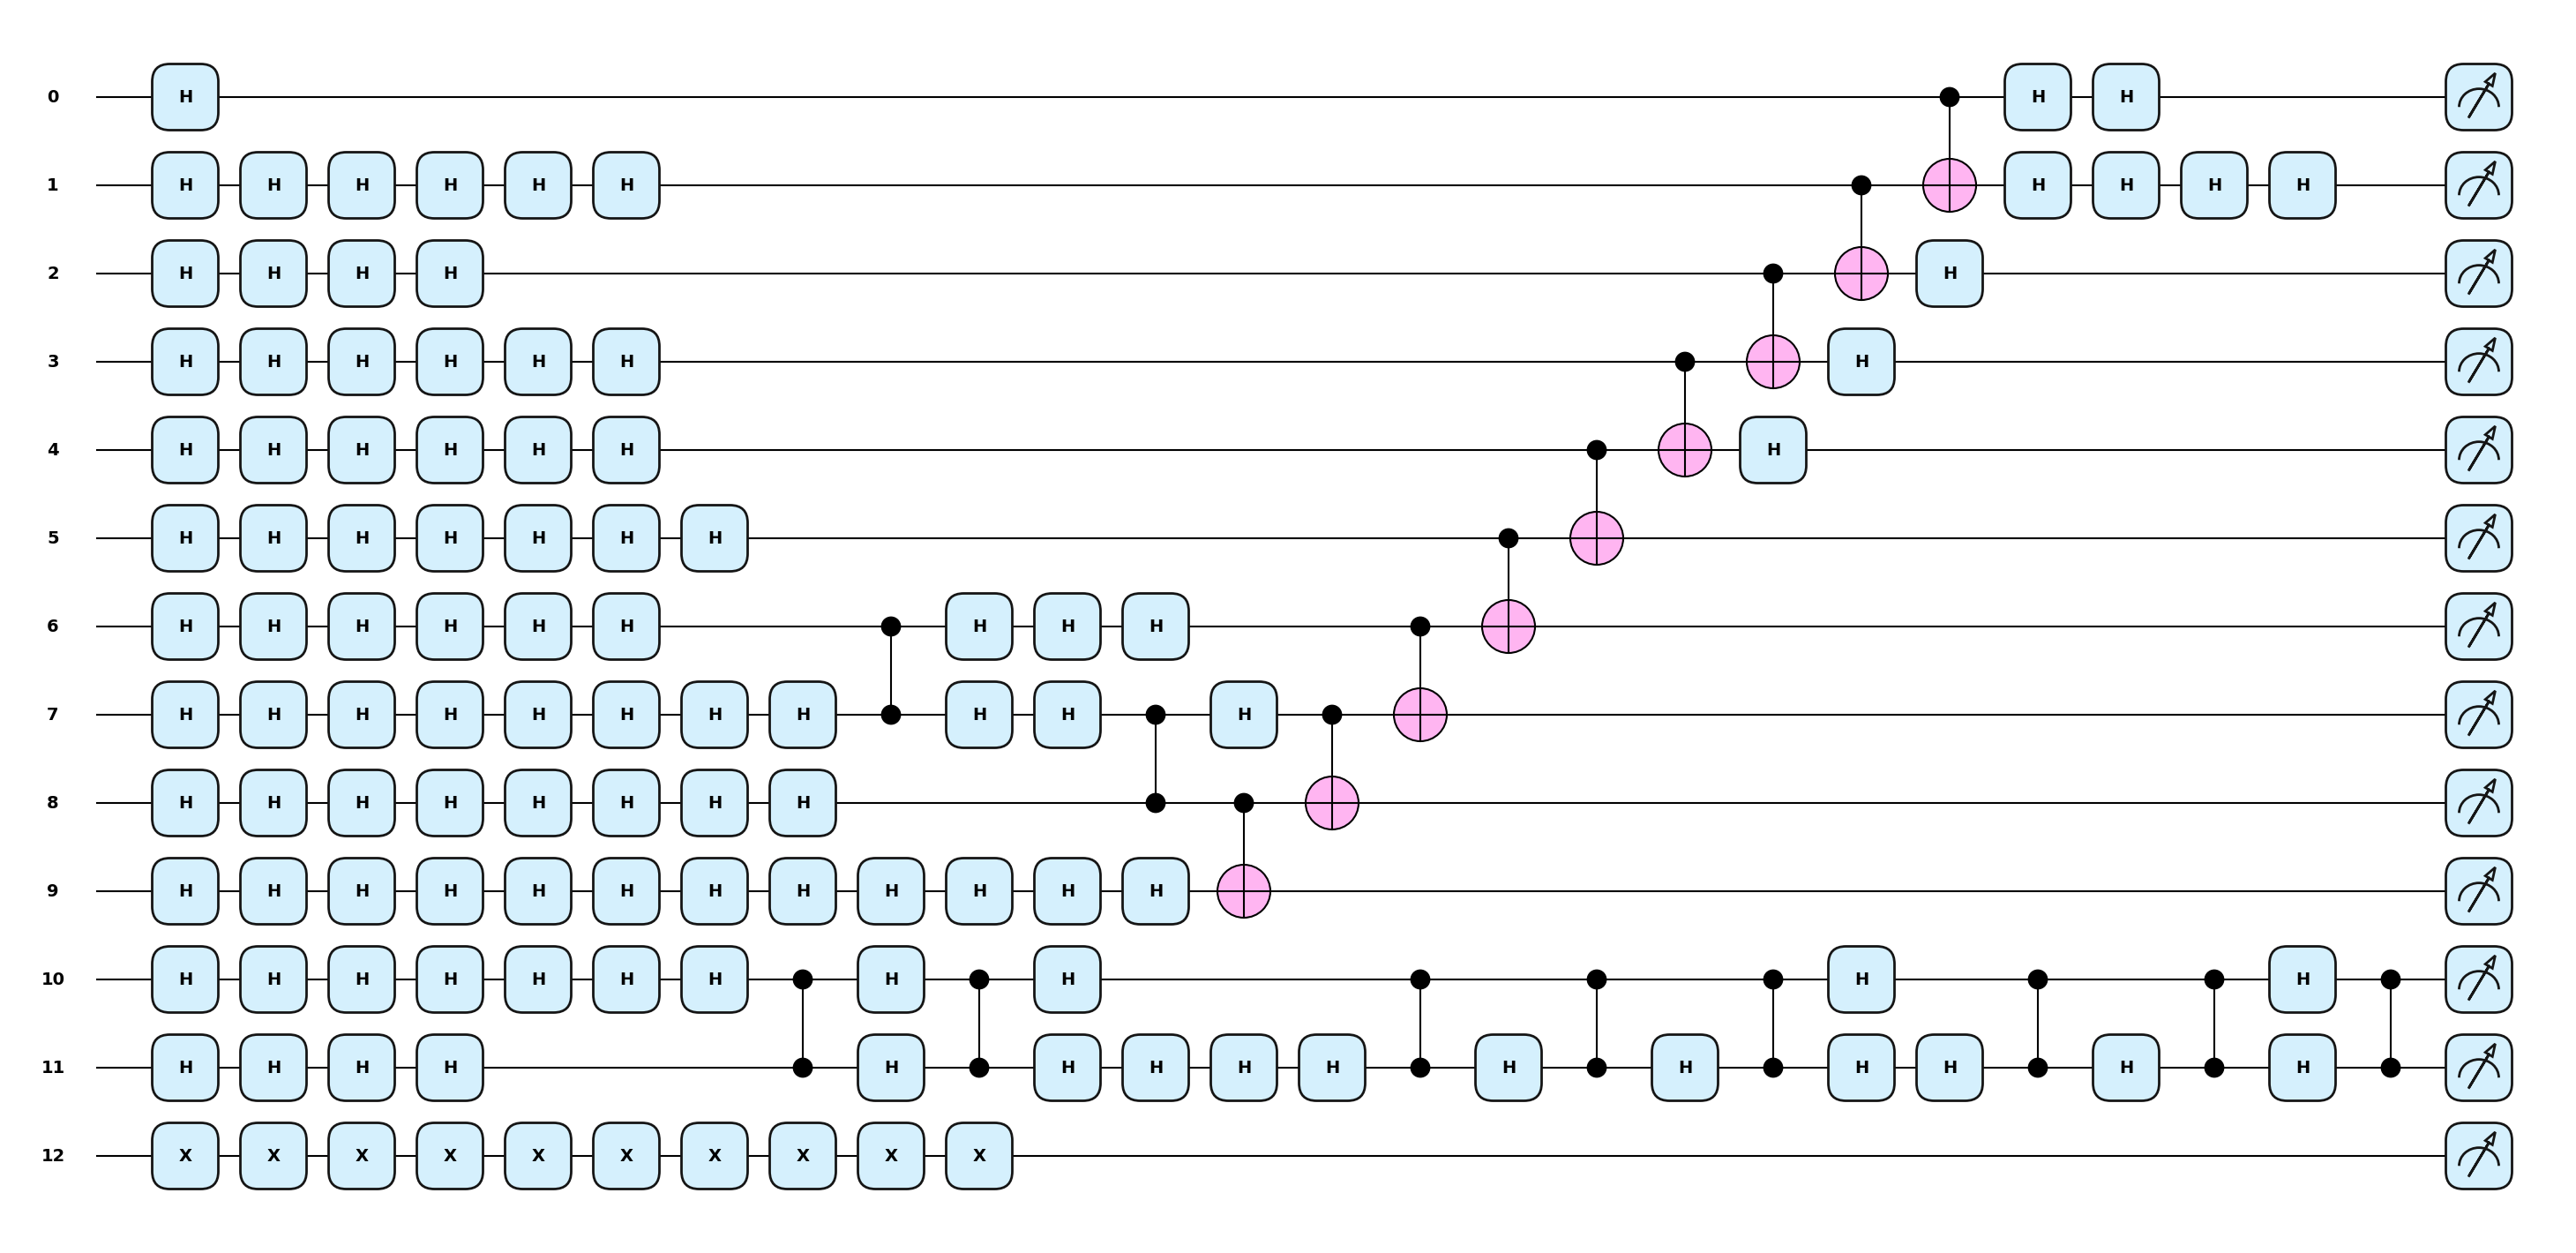

In [4]:
info1 = optimize2q(qnode=circuit)
show_info(info1)

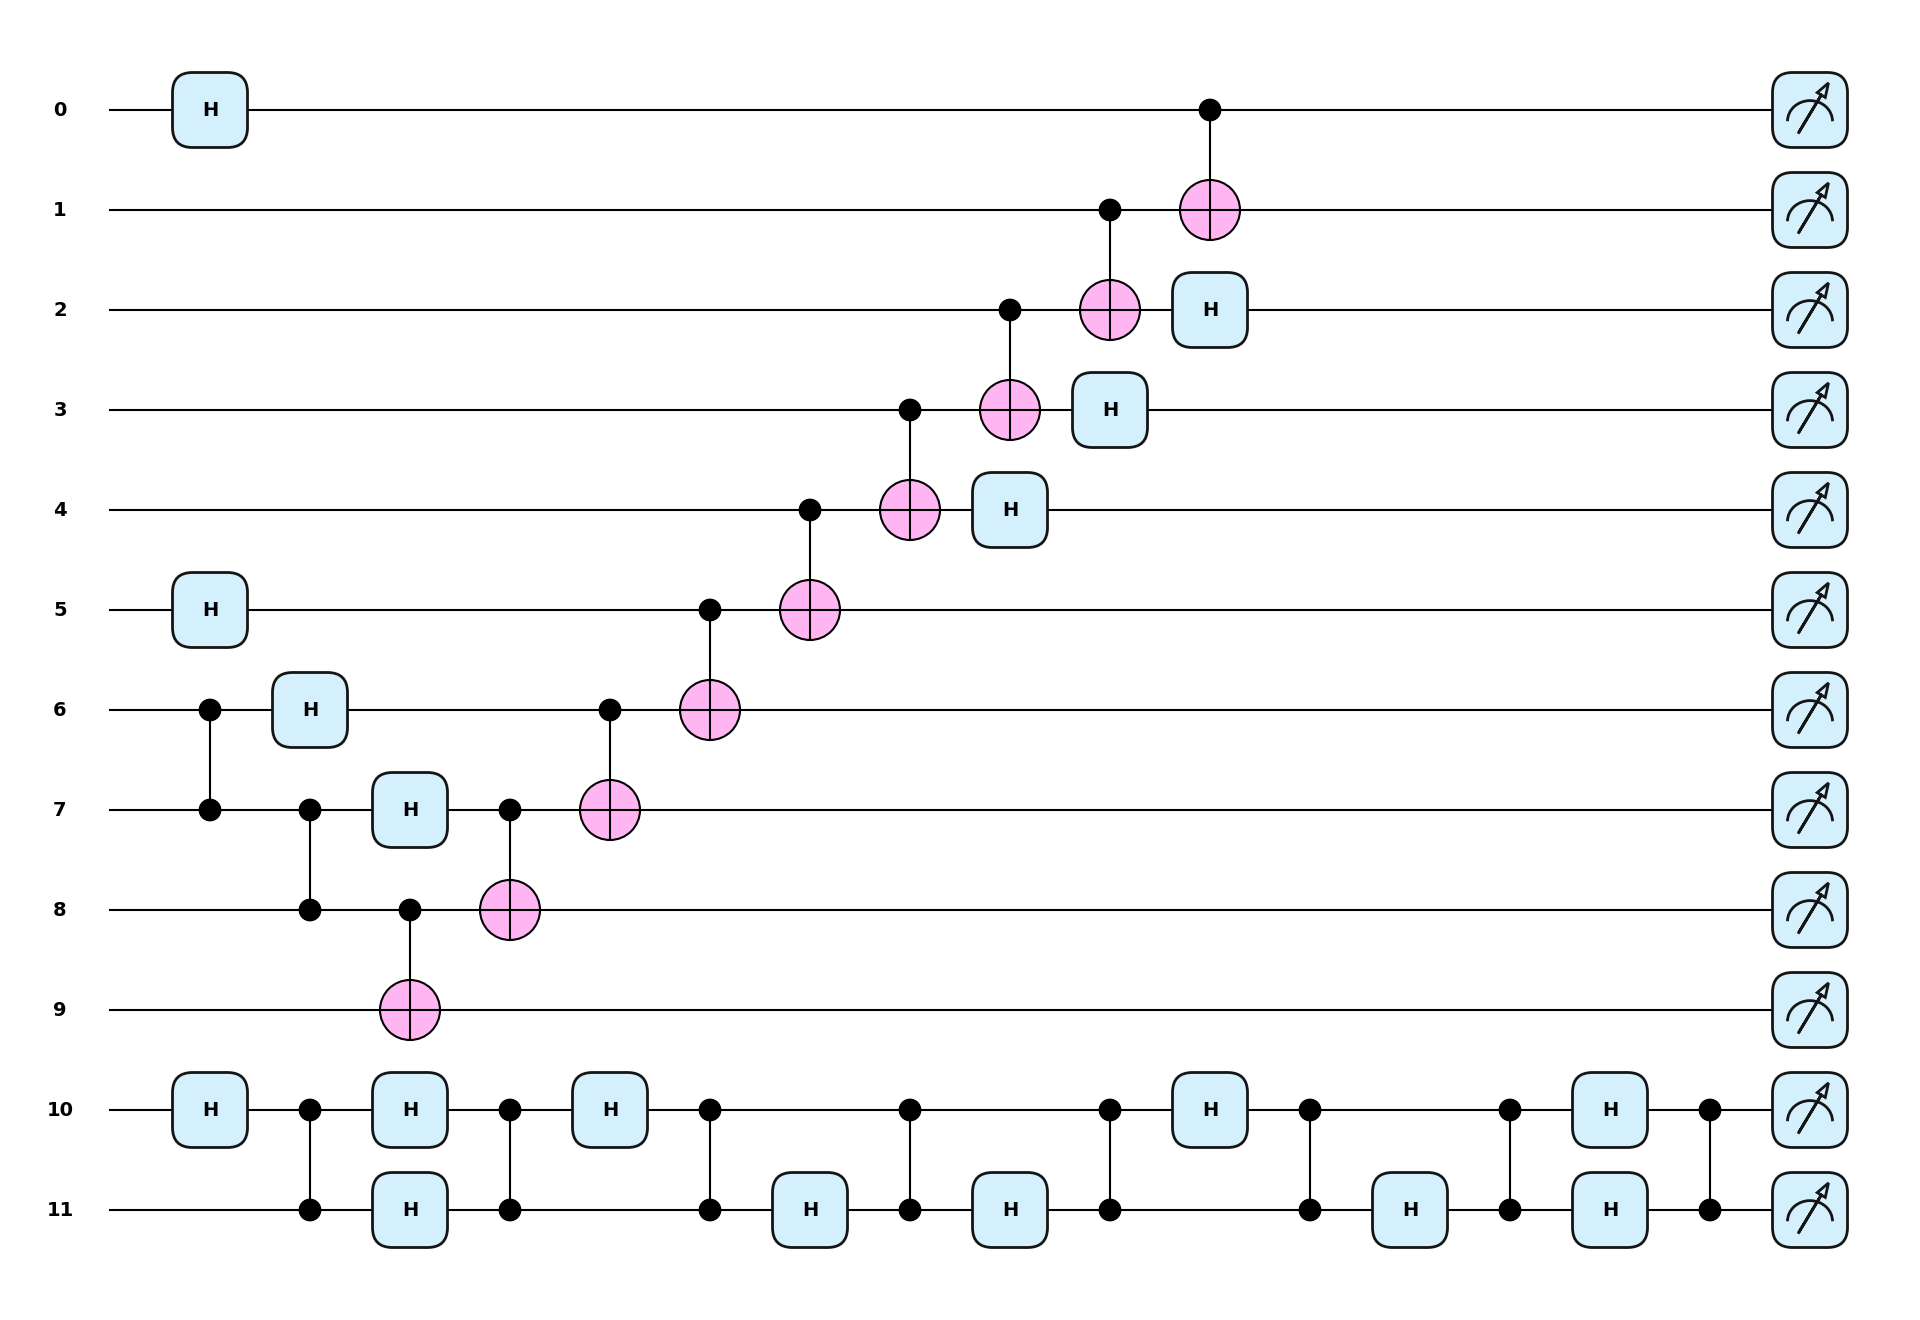

In [5]:
info2 = optimize1q(circuit_info=info1)
show_info(info2)

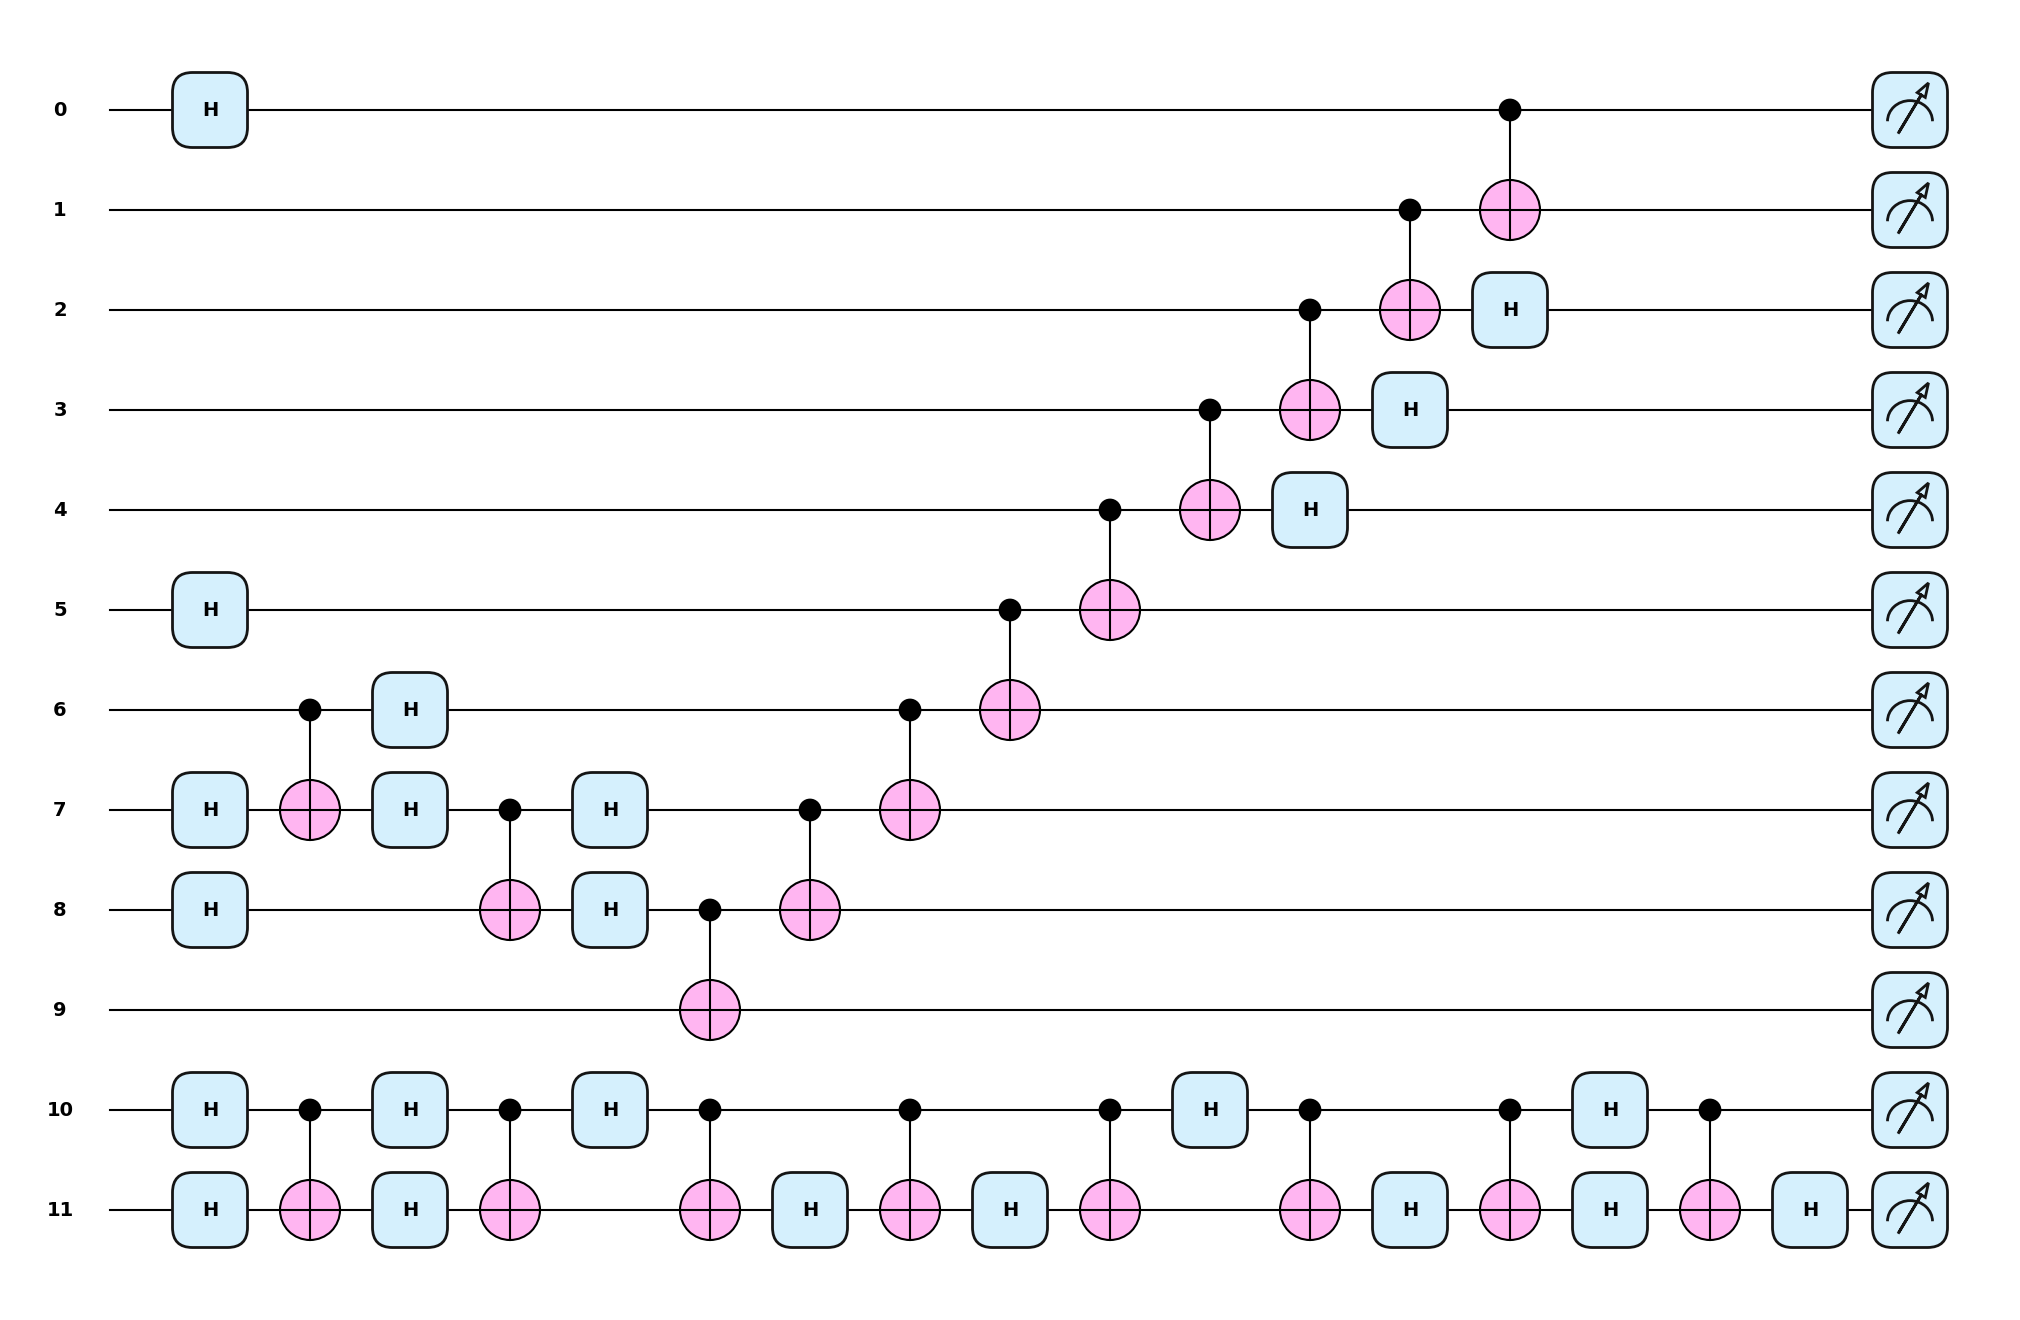

In [6]:
info3 = optimize12q(circuit_info=replace_gate(info2))
show_info(info3)

approach #1

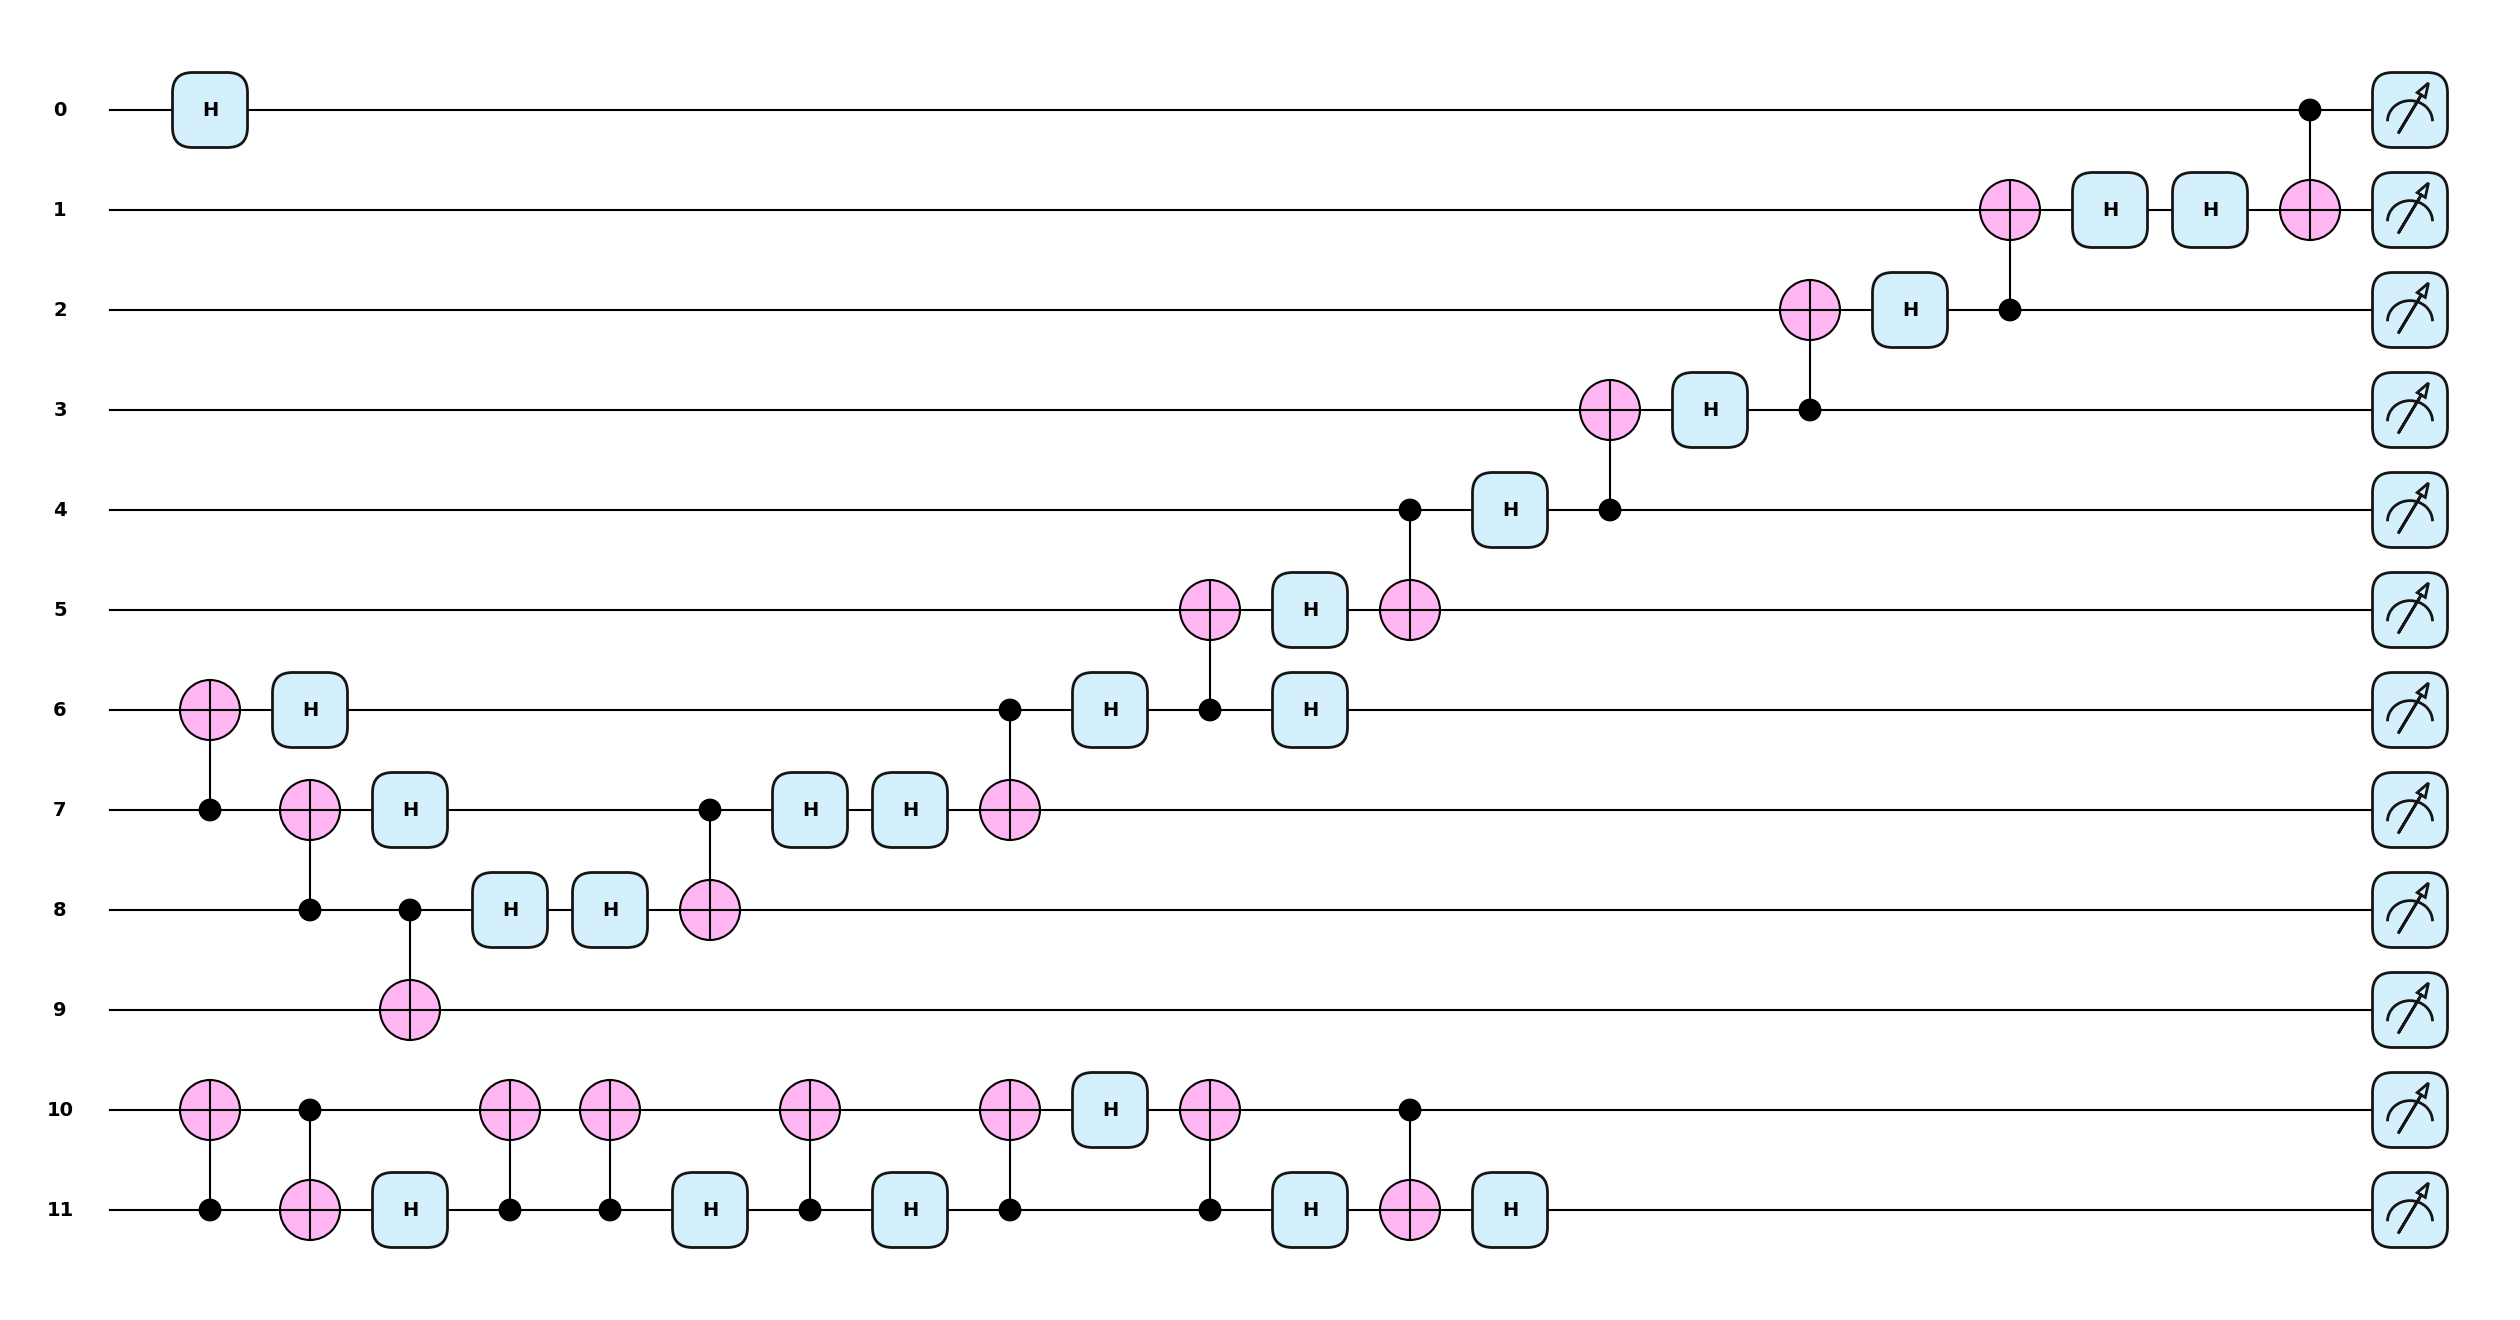

In [7]:
info4 = optimizeJoint_aug(circuit_info=info3)
show_info(info4)

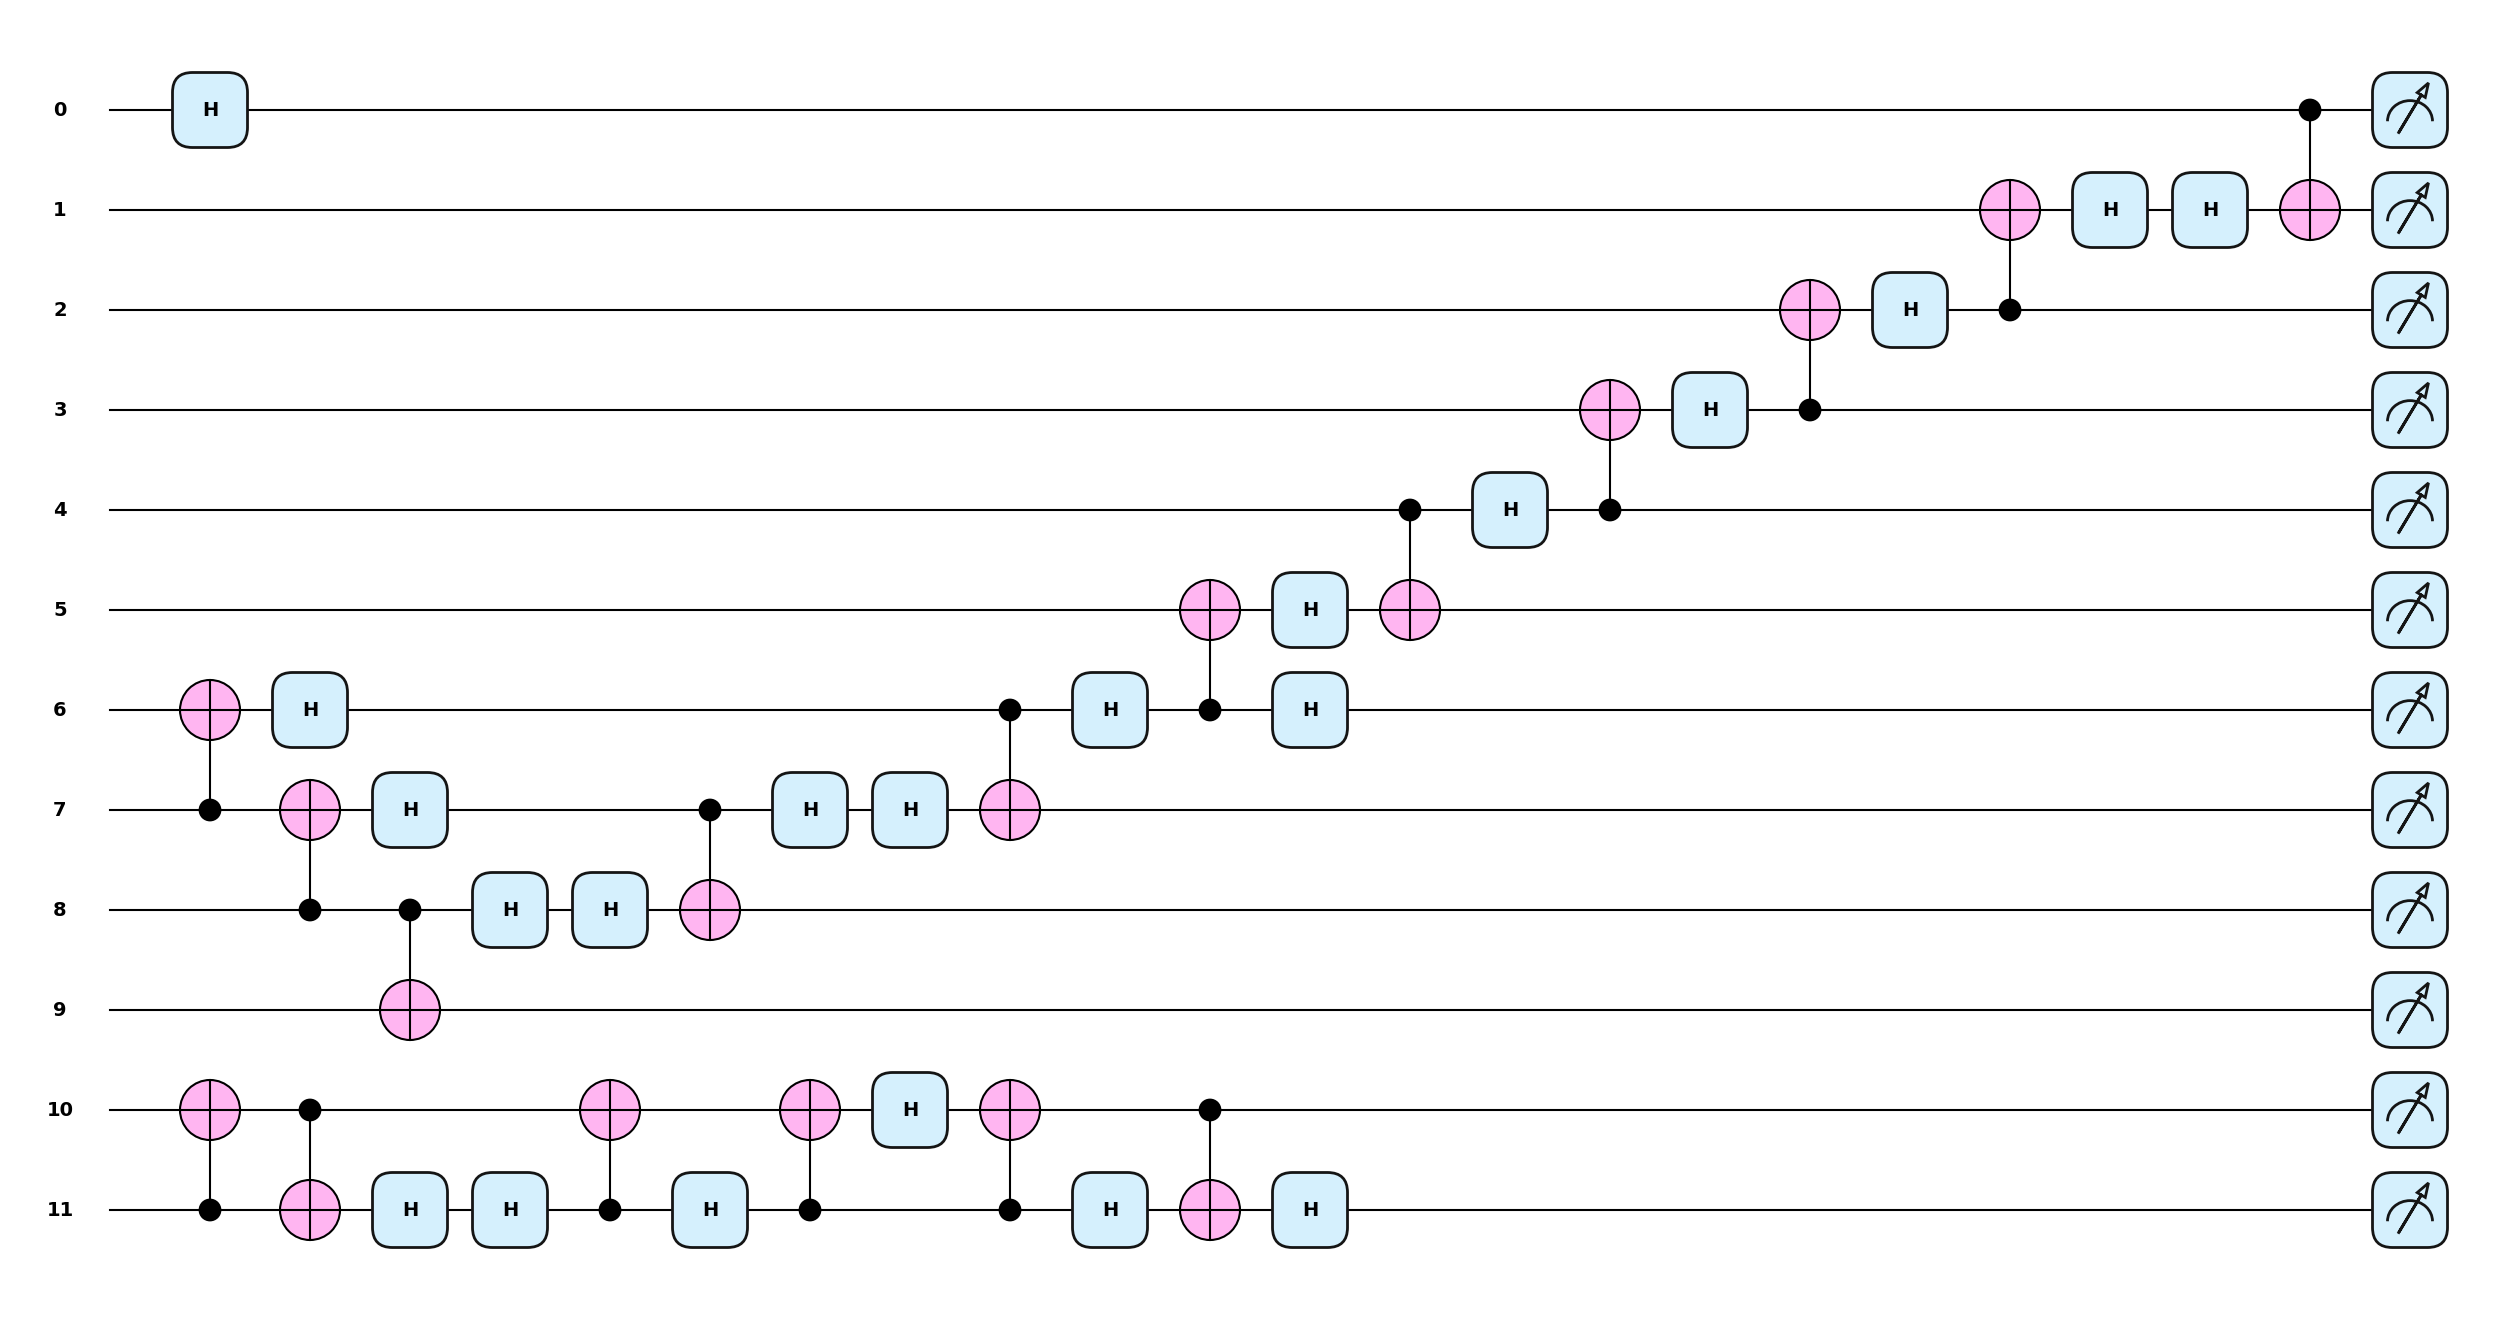

In [8]:
info5 = optimize2q(circuit_info=info4)
show_info(info5)

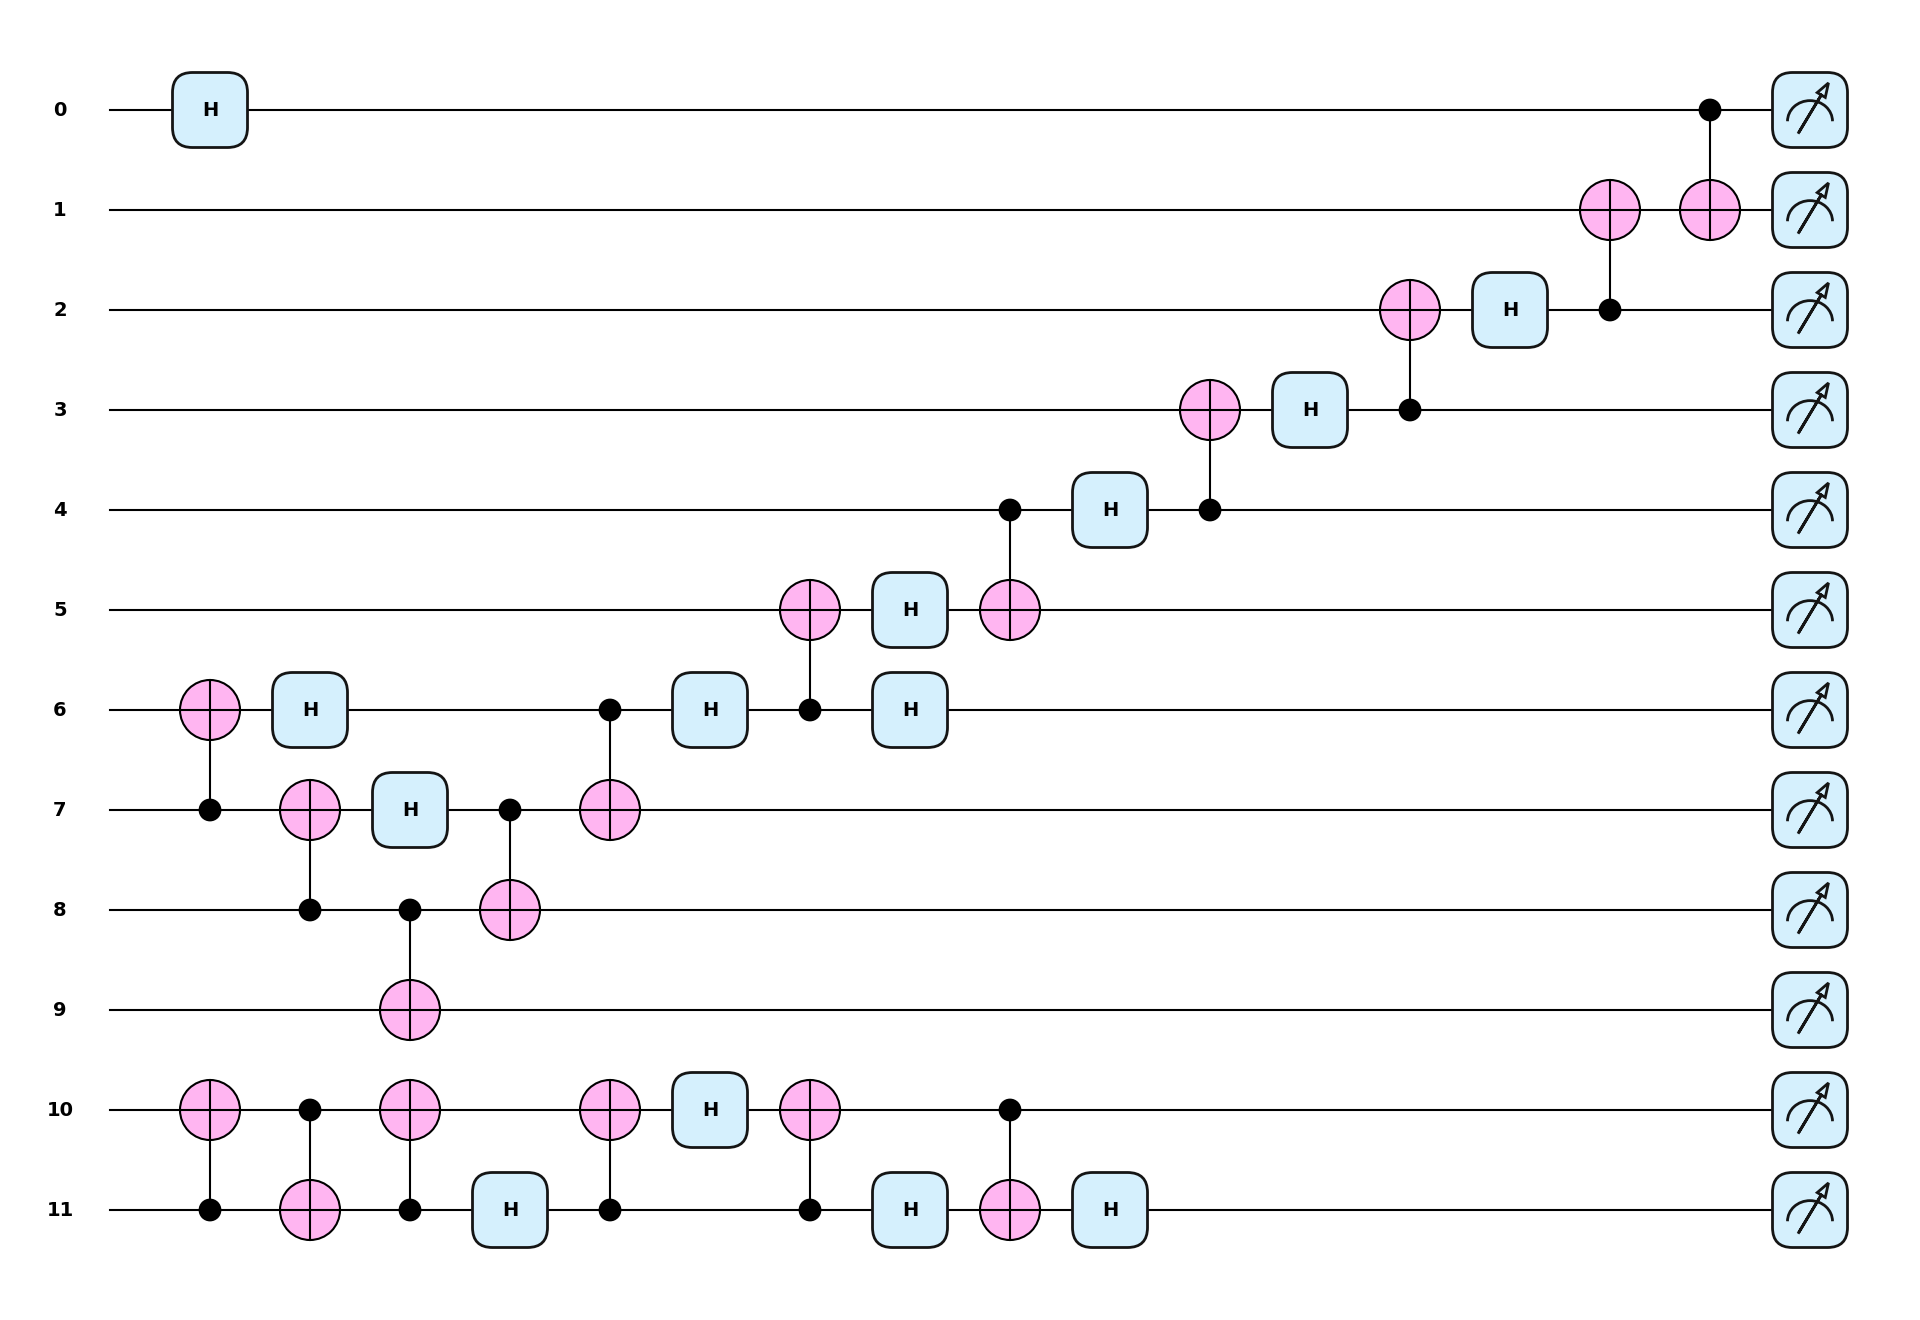

In [9]:
info6 = optimize1q(circuit_info=info5)
show_info(info6)

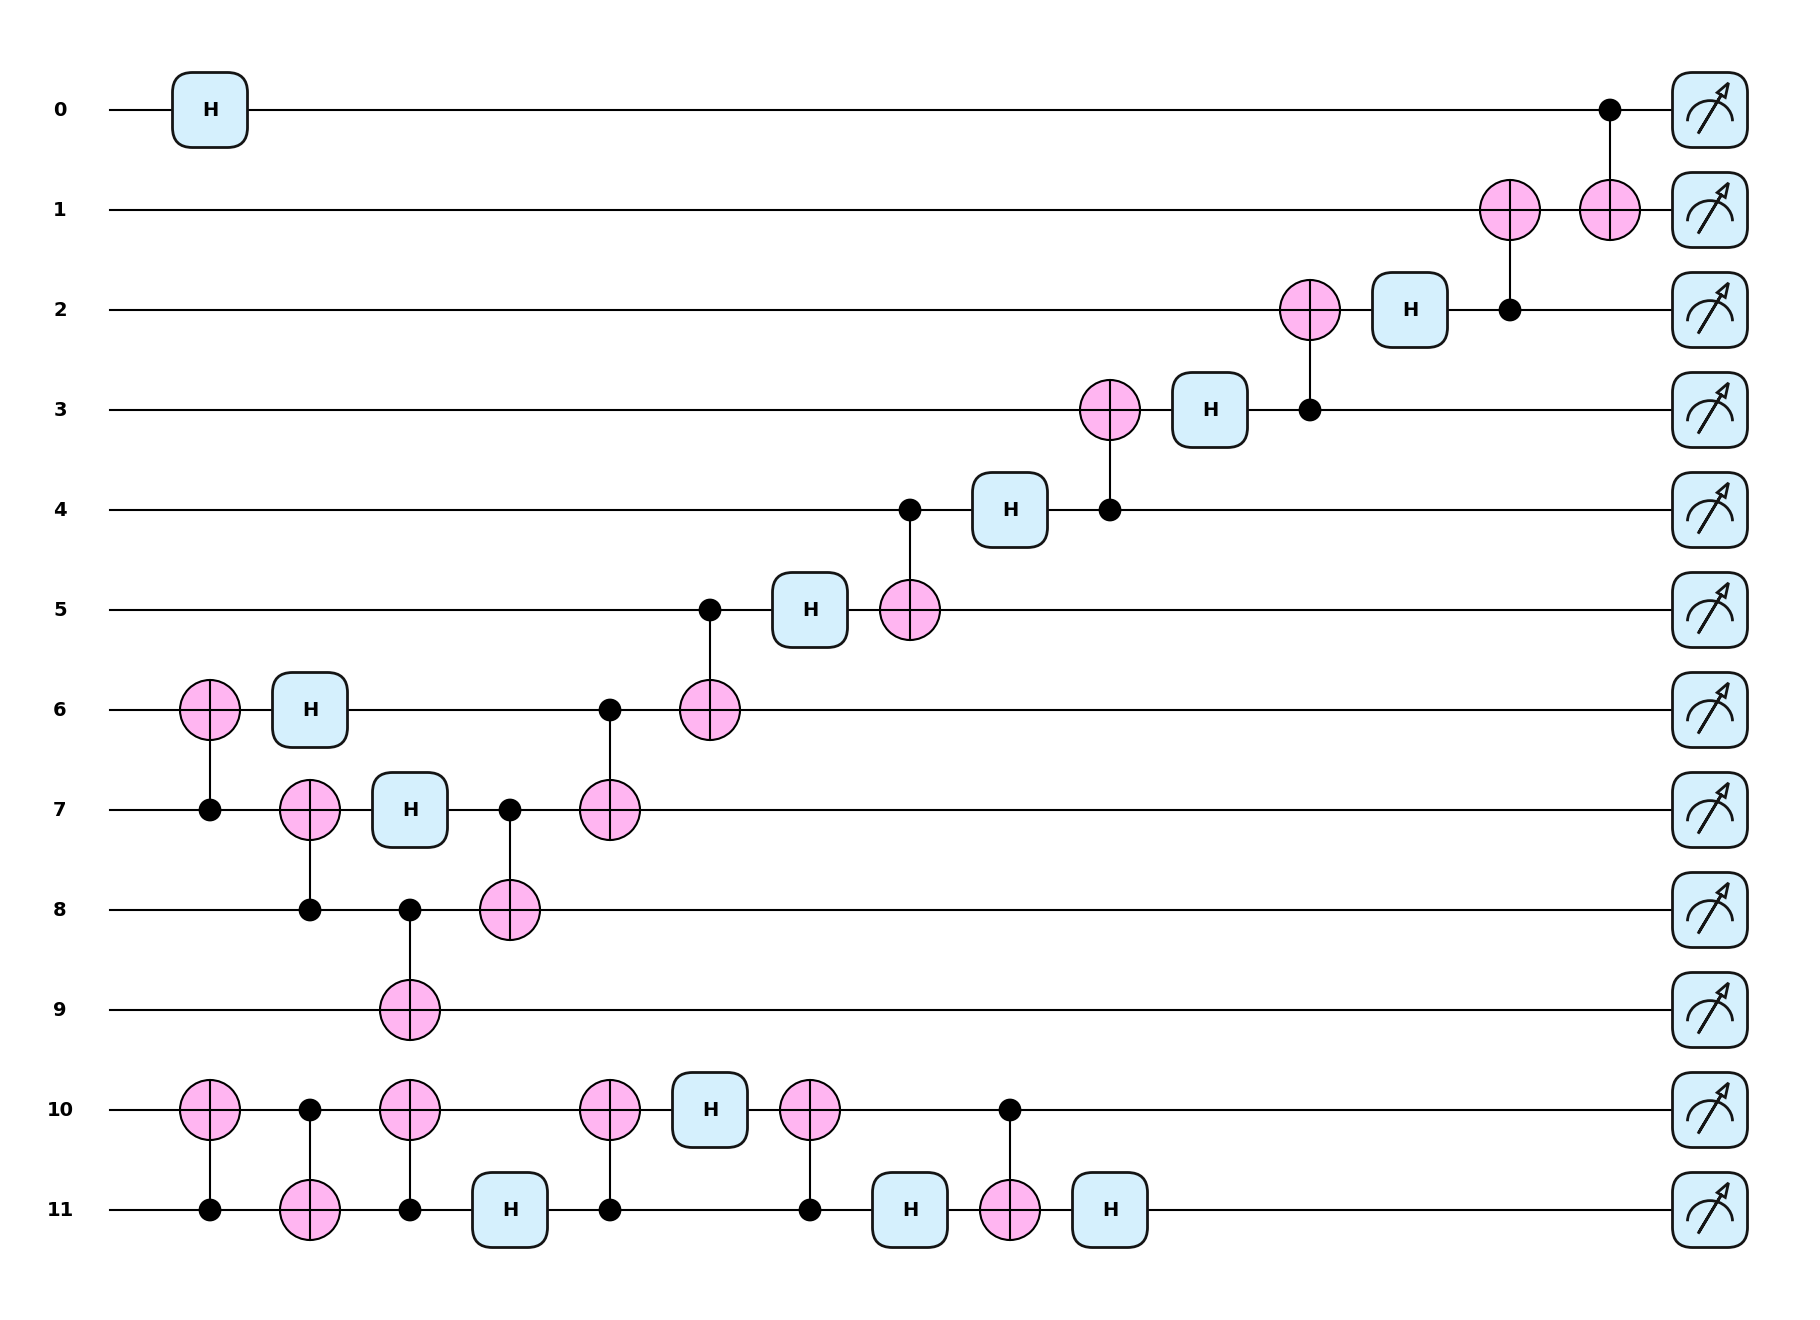

In [10]:
info7 = optimizeJoint(circuit_info=info6)
show_info(info7)

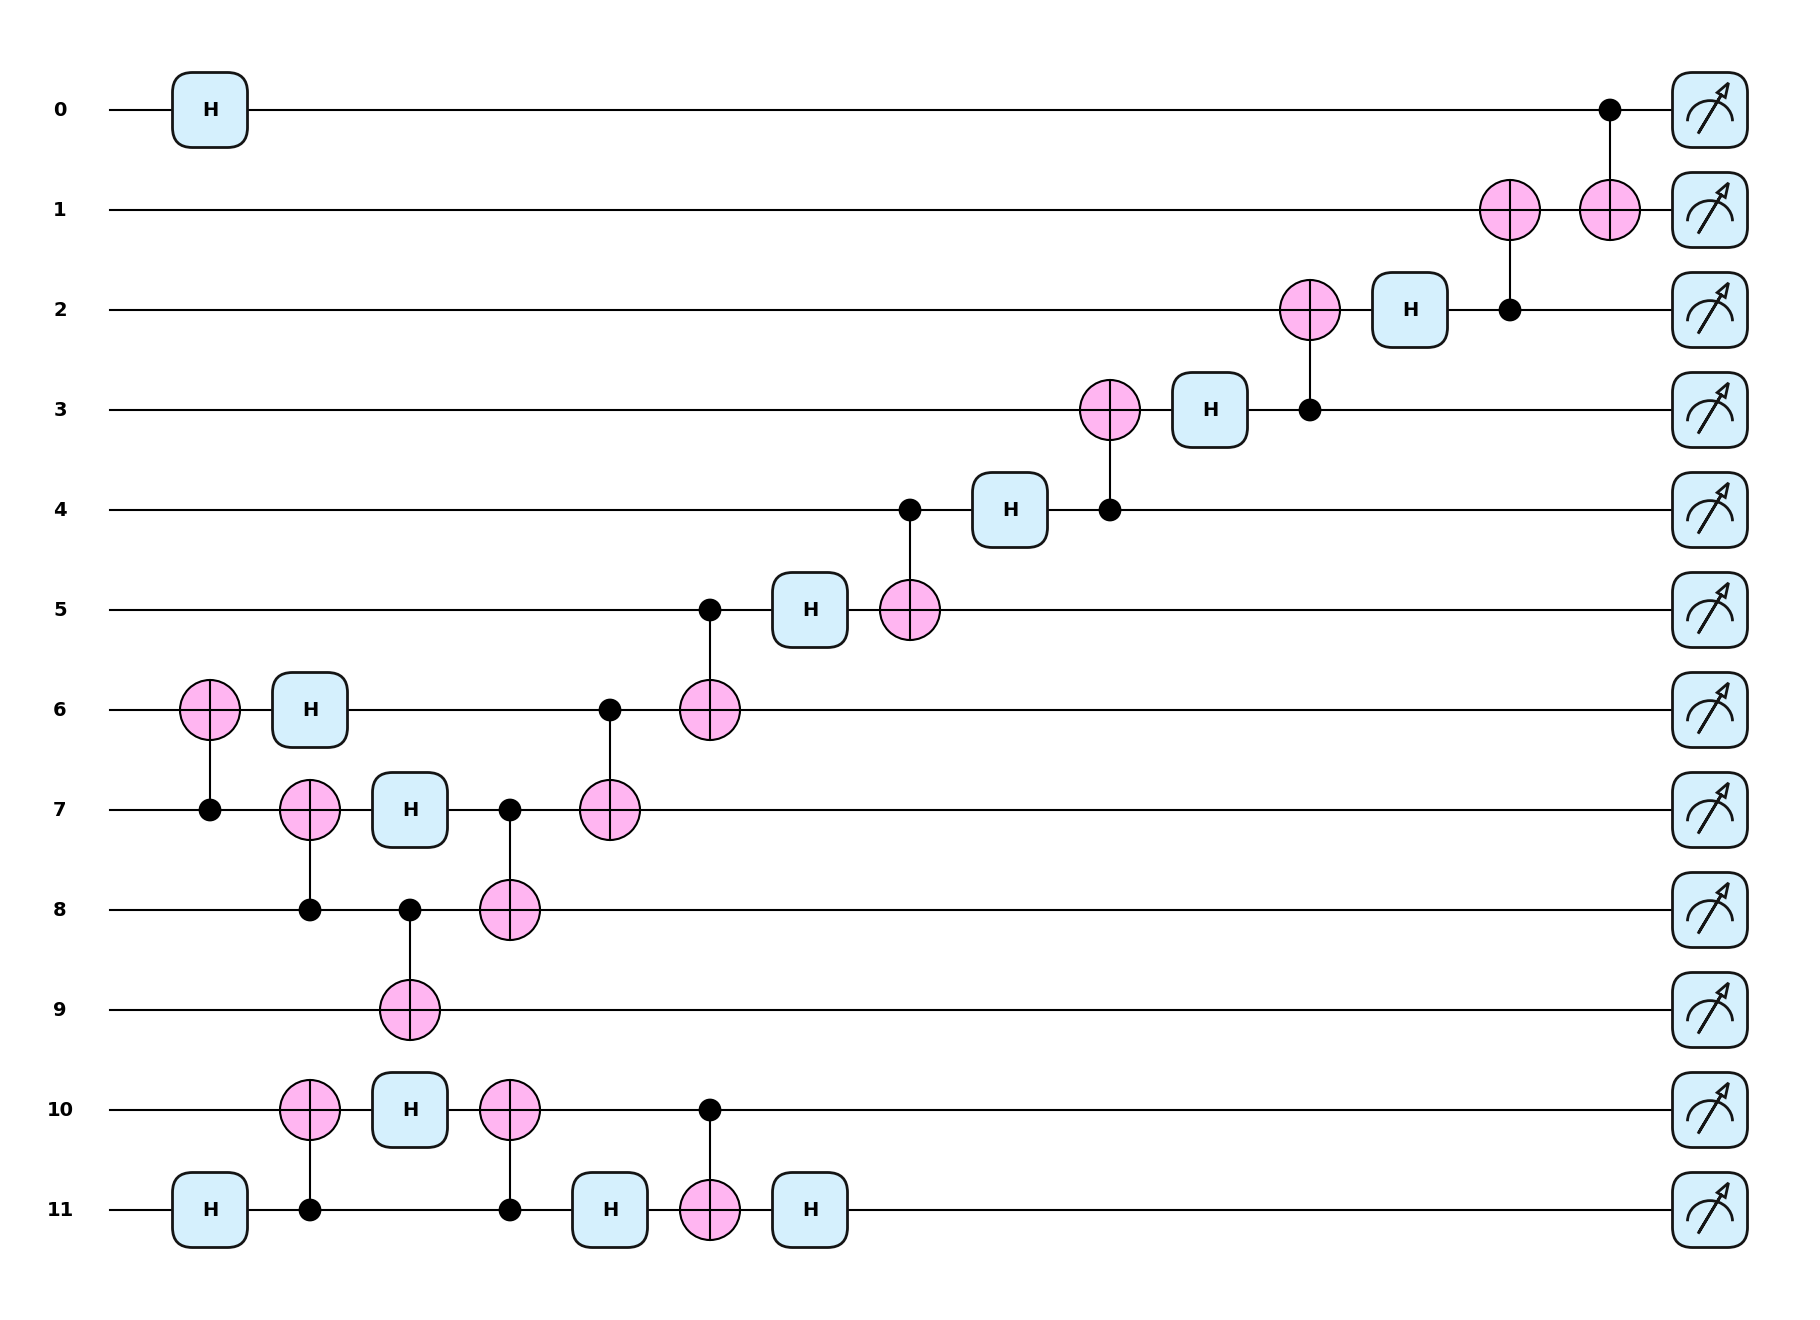

In [ ]:
swap = [{'label': 'CNOT', 'params': [], 'wires': [11, 10]},
 {'label': 'CNOT', 'params': [], 'wires': [10, 11]},
 {'label': 'CNOT', 'params': [], 'wires': [11, 10]}]
for g in swap:
    info7.remove(g) # the wire order does not have a meaning in high-level circuits

show_info(info7)

In [24]:
[elem for elem in info7 if 10 in elem["wires"] or 11 in elem["wires"]]

[{'label': 'Hadamard', 'params': [], 'wires': [11]},
 {'label': 'CNOT', 'params': [], 'wires': [11, 10]},
 {'label': 'Hadamard', 'params': [], 'wires': [10]},
 {'label': 'CNOT', 'params': [], 'wires': [11, 10]},
 {'label': 'Hadamard', 'params': [], 'wires': [11]},
 {'label': 'CNOT', 'params': [], 'wires': [10, 11]},
 {'label': 'Hadamard', 'params': [], 'wires': [11]}]

In [30]:
group_info = [elem for elem in info7 if 10 in elem["wires"] or 11 in elem["wires"]]
matrix, wires = info_to_qnode_matrix(group_info)
matrix

array([[ 0.5,  0.5,  0.5,  0.5],
       [-0.5,  0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [-0.5,  0.5, -0.5,  0.5]])

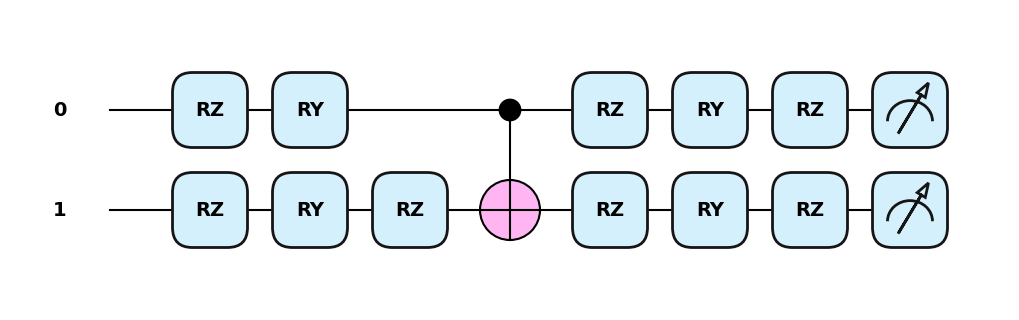

global phase: π/2
       ┌─────────┐   ┌───────────┐     ┌──────────┐  ┌───────┐              
q_0: ──┤ Ry(π/2) ├───┤ Rz(-3π/4) ├──■──┤ Rz(-π/4) ├──┤ Ry(π) ├──────────────
     ┌─┴─────────┴──┐└┬──────────┤┌─┴─┐├─────────┬┘┌─┴───────┴──┐┌─────────┐
q_1: ┤ Rz(-0.45287) ├─┤ Ry(-π/2) ├┤ X ├┤ Rz(π/2) ├─┤ Ry(2.6887) ├┤ Rz(π/2) ├
     └──────────────┘ └──────────┘└───┘└─────────┘ └────────────┘└─────────┘


In [29]:
matrix, wires = info_to_qnode_matrix(group_info)

# penny unitary synthesis
dev = qml.device("default.qubit", wires=2)
@qml.qnode(dev)
def circuit():
    qml.QubitUnitary(matrix, wires=[0,1])
    return qml.state()
compiled = qml.compile(
    circuit,
    basis_set=[qml.Hadamard, qml.RY, qml.RZ, qml.CNOT]
)
show_circuit((compiled))

# qiksit unitary synthesis
basis = ['h','ry','rz','cx']
qc = QuantumCircuit(2)
qc.unitary(matrix, range(2))
synth_pass = UnitarySynthesis(basis_gates=basis) # basis_gates=basis
pm = PassManager(synth_pass)
optimized_circuit = pm.run(qc)
print(optimized_circuit.draw('text'))  

In [ ]:
from qiskit import QuantumCircuit
from qiskit.transpiler.passes import UnitarySynthesis
from qiskit.transpiler import PassManager

def qiskit_optimization(u):
    basis = ['h','ry','rz','cx']
    qc = QuantumCircuit(2)
    qc.unitary(u, range(2))
    synth_pass = UnitarySynthesis(basis_gates=basis) # basis_gates=basis
    pm = PassManager(synth_pass)
    optimized_circuit = pm.run(qc)
    
    qnoe_temp = qml.from_qiskit(optimized_circuit)
    dev = qml.device("default.qubit", wires=2)
    tg = To_graph(qnode=qml.QNode(qnoe_temp, dev))
    circuit_nodes = tg.circuit_nodes
    return circuit_nodes

In [ ]:
def pennylane_optimization(u):
    dev = qml.device("default.qubit", wires=2)

    @qml.qnode(dev)
    def circuit():
        qml.QubitUnitary(u, wires=[0,1])
        return qml.state()

    # compile with your chosen basis set
    compiled = qml.compile(
        circuit,
        basis_set=[qml.Hadamard, qml.RY, qml.RZ, qml.CNOT]
    )

    tg = To_graph(qnode=compiled)
    return tg.circuit_nodes